In [1]:
import numpy as np
import numba
from numba import jit

In [113]:
N_CARDS = 3
N_ACTIONS = 2
N_GAMES = 2000
POPULATION_SIZE = 50
TOURNAMENT_PROB = 0.7
CROSSOVER_PROB = 0.6
MUTATION_PROB = 0.1/N_CARDS*N_ACTIONS
CREEP_RATE = 0.005
CARDS = np.arange(N_CARDS)
INDIVIDUALS = np.arange(POPULATION_SIZE)
MAX_SCORE = N_GAMES*POPULATION_SIZE*POPULATION_SIZE*2

<img src="kuhns_poker_no_fold.png">

In [114]:
@jit(nopython=True)
def play(p1, p2):

    p1_card, p2_card =  np.random.permutation(CARDS)[:2]
    p1_bets =  np.random.rand() < p1[2*p1_card]
   
    
    if(p1_bets):
        p2_bets = np.random.rand() < p2[2*p2_card]

        if(p2_bets):
            if(p1_card > p2_card):
                return (2,-2)
            else: 
                return (-2,2)
        elif(not p2_bets):
            return (1,-1)
        
    elif(not p1_bets):
        p2_bets = np.random.rand() < p2[2*p2_card+1]
        
        if(p2_bets):
            p1_bets_again =  np.random.rand() < p1[2*p1_card+1]
            
            if(p1_bets_again):
                if(p1_card > p2_card):
                    return (2,-2)
                else: 
                    return (-2,2)
            elif(not p1_bets_again):
                return (-1,1)
        
        elif(not p2_bets):
            if(p1_card > p2_card):
                return (1,-1)
            else: 
                return (-1,1)


In [115]:
@jit(nopython=True)
def evaluate(population_1, population_2):
 
    fitness_1 = np.zeros(POPULATION_SIZE)
    fitness_2 = np.zeros(POPULATION_SIZE) 

    for player in INDIVIDUALS:
        for opponent in INDIVIDUALS:
            for game in range(N_GAMES):
                player_score, opponent_score = play(population_1[player], population_2[opponent])
                fitness_1[player] += player_score
                fitness_2[opponent] += opponent_score
    

    return (fitness_1/(POPULATION_SIZE*N_GAMES), fitness_2/(POPULATION_SIZE*N_GAMES))

In [116]:
@jit(nopython=True)
def tournament_selection(population, fitness):
    
    p = np.random.permutation(POPULATION_SIZE)
    
    i1 = p[0]
    i2 = p[1]
    
    if(fitness[i1] > fitness[i2]):
        i_max = i1
        i_min = i2
    else:
        i_max = i2
        i_min = i1
    
    if(np.random.rand() < TOURNAMENT_PROB):
        return i_max
    else:
        return i_min
            
def wheel_selection(population, fitness):
    temp = fitness + np.min(fitness)
    distribution = temp/np.sum(temp)
    return np.random.choice(np.arange(POPULATION_SIZE), p= distribution)
    

In [117]:
@jit(nopython=True)
def crossover(individual_1, individual_2):
    if(np.random.rand() < CROSSOVER_PROB):
        crossover_point = np.random.randint(len(individual_1))

        child_1 = np.concatenate((individual_1[:crossover_point],individual_2[crossover_point:]))
        child_2 = np.concatenate((individual_2[:crossover_point],individual_1[crossover_point:]))
    
        return (child_1, child_2)
    else:
        return (individual_1, individual_2)

In [118]:
@jit(nopython=True)
def mutate(individual):
    
    creeps = CREEP_RATE*np.random.randn(len(individual))
    mutations = (np.random.rand(len(individual)) < MUTATION_PROB)*creeps
    mutated_individual = individual + mutations
    mutated_individual[mutated_individual < 0] = 0
    mutated_individual[mutated_individual > 1] = 1

    return mutated_individual

In [119]:
def print_player(player):

    print("Card \t      a0 prob \t      a2 prob")
    for card in range(N_CARDS):
         print("  {:d}\t|\t{:.0f}%\t|\t{:.0f}%".format(card, player[card*2]*100, player[card*2+1]*100))

In [120]:
p1 = np.random.rand(POPULATION_SIZE, N_CARDS* N_ACTIONS)
p2 = np.random.rand(POPULATION_SIZE, N_CARDS* N_ACTIONS)
new_p1 = p1.copy()
new_p2 = p2.copy()

f1,f2 = evaluate(p1, p2)

In [125]:
p1_turn = True
for generation in range(20000):
    
    if(generation % 100) : p1_turn = not p1_turn

    for i in range(0,POPULATION_SIZE,2):
        if(p1_turn):
            ind11 = tournament_selection(p1,f1)
            ind12 = tournament_selection(p1,f1)
            
            child_11, child_12 = crossover(p1[ind11], p1[ind12])
            
            child_11 = mutate(child_11)
            child_12 = mutate(child_12)
            
            new_p1[i] = child_11
            new_p1[i+1] = child_12
            
            best_indivudal_1 = np.argmax(f1)
            
            new_p1[0] = p1[best_indivudal_1]
            
            p1 = new_p1.copy()
        
        else:
            
            ind21 = tournament_selection(p2,f2)
            ind22 = tournament_selection(p2,f2)
        
        
            child_21, child_22 = crossover(p2[ind21], p2[ind22])
        
        
            child_21 = mutate(child_21)
            child_22 = mutate(child_22)
        
        
            new_p2[i] = child_21
            new_p2[i+1] = child_22
        
    
            best_indivudal_2 = np.argmax(f2)

            new_p2[0] = p2[best_indivudal_2]

            p2 = new_p2.copy()
    
    f1,f2 = evaluate(p1,p2)
    
    
    if(generation % 100 == 0):
        print("Generation: ", generation)
        print("Fitness: ", np.max(f1), np.max(f2))
        #print("Strategy player 1: ")
        #print_player(p1[np.argmax(f1)])
        print("Strategy player 2: ")
        print_player(p2[np.argmax(f2)])
        
        print("---------------------------------------")
    


Generation:  0
Fitness:  -0.03349 0.05015
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	0%	|	42%
  1	|	47%	|	57%
  2	|	99%	|	84%
---------------------------------------
Generation:  100
Fitness:  -0.03382 0.052
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	1%	|	42%
  1	|	45%	|	55%
  2	|	100%	|	84%
---------------------------------------
Generation:  200
Fitness:  -0.03287 0.04811
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	0%	|	40%
  1	|	46%	|	56%
  2	|	99%	|	84%
---------------------------------------
Generation:  300
Fitness:  -0.02894 0.04869
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	1%	|	38%
  1	|	45%	|	55%
  2	|	99%	|	82%
---------------------------------------
Generation:  400
Fitness:  -0.03191 0.05072
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	0%	|	36%
  1	|	43%	|	54%
  2	|	99%	|	83%
---------------------------------------
Generation:  500
Fitness:  -0.03716 0.05497
Strategy player 2: 
Card 	   

Generation:  4400
Fitness:  -0.05357 0.07146
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	0%	|	3%
  1	|	10%	|	39%
  2	|	100%	|	99%
---------------------------------------
Generation:  4500
Fitness:  -0.05569 0.07246
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	0%	|	0%
  1	|	11%	|	41%
  2	|	100%	|	100%
---------------------------------------
Generation:  4600
Fitness:  -0.0504 0.0772
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	1%	|	1%
  1	|	12%	|	39%
  2	|	100%	|	100%
---------------------------------------
Generation:  4700
Fitness:  -0.0458 0.06525
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	2%	|	2%
  1	|	11%	|	40%
  2	|	100%	|	100%
---------------------------------------
Generation:  4800
Fitness:  -0.04019 0.05961
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	2%	|	2%
  1	|	12%	|	40%
  2	|	99%	|	100%
---------------------------------------
Generation:  4900
Fitness:  -0.03948 0.05521
Strategy player 2: 


Generation:  8800
Fitness:  -0.0856 0.10556
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	1%	|	44%
  1	|	50%	|	4%
  2	|	100%	|	94%
---------------------------------------
Generation:  8900
Fitness:  -0.09591 0.11371
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	0%	|	47%
  1	|	54%	|	5%
  2	|	99%	|	93%
---------------------------------------
Generation:  9000
Fitness:  -0.0996 0.1166
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	1%	|	48%
  1	|	55%	|	3%
  2	|	100%	|	94%
---------------------------------------
Generation:  9100
Fitness:  -0.10462 0.12439
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	1%	|	49%
  1	|	57%	|	0%
  2	|	100%	|	97%
---------------------------------------
Generation:  9200
Fitness:  -0.10038 0.11813
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	0%	|	52%
  1	|	58%	|	0%
  2	|	99%	|	98%
---------------------------------------
Generation:  9300
Fitness:  -0.10404 0.1246
Strategy player 2: 
Card 	

Generation:  13200
Fitness:  -0.01963 0.04372
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	1%	|	43%
  1	|	43%	|	1%
  2	|	99%	|	100%
---------------------------------------
Generation:  13300
Fitness:  -0.02234 0.04286
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	2%	|	43%
  1	|	37%	|	1%
  2	|	100%	|	100%
---------------------------------------
Generation:  13400
Fitness:  -0.0269 0.04778
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	2%	|	41%
  1	|	36%	|	1%
  2	|	99%	|	99%
---------------------------------------
Generation:  13500
Fitness:  -0.03104 0.05023
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	0%	|	39%
  1	|	36%	|	1%
  2	|	99%	|	100%
---------------------------------------
Generation:  13600
Fitness:  -0.03552 0.05366
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	0%	|	38%
  1	|	35%	|	1%
  2	|	98%	|	100%
---------------------------------------
Generation:  13700
Fitness:  -0.04038 0.05817
Strategy player

Generation:  17600
Fitness:  -0.01433 0.03004
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	2%	|	2%
  1	|	19%	|	0%
  2	|	100%	|	99%
---------------------------------------
Generation:  17700
Fitness:  -0.01497 0.03024
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	3%	|	2%
  1	|	21%	|	1%
  2	|	99%	|	99%
---------------------------------------
Generation:  17800
Fitness:  -0.00725 0.02804
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	2%	|	2%
  1	|	19%	|	0%
  2	|	99%	|	100%
---------------------------------------
Generation:  17900
Fitness:  -0.0064 0.0231
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	2%	|	4%
  1	|	20%	|	1%
  2	|	100%	|	99%
---------------------------------------
Generation:  18000
Fitness:  -0.00615 0.02235
Strategy player 2: 
Card 	      a0 prob 	      a2 prob
  0	|	0%	|	5%
  1	|	19%	|	1%
  2	|	100%	|	100%
---------------------------------------
Generation:  18100
Fitness:  -0.00916 0.02349
Strategy player 2: 
C

## Dominant Strategy for player 2

| Card | a0   | a2   |
|------|------|------|
| 0    | 0%   | 33%  |
| 1    | 33%  | ?    |
| 2    | 100% | 100% |

## Best player 1 strategy

In [126]:
print_player(p1[np.argsort(f1)[-1]])

Card 	      a0 prob 	      a2 prob
  0	|	39%	|	1%
  1	|	0%	|	13%
  2	|	53%	|	100%


## Best player 2 strategy

In [127]:
print_player(p2[np.argsort(f2)[-1]])

Card 	      a0 prob 	      a2 prob
  0	|	1%	|	40%
  1	|	29%	|	1%
  2	|	100%	|	100%


<img src="kuhns_poker_no_fold.png">

In [41]:
%timeit evaluate(p1,p2)

235 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
%timeit evaluate.py_func(p1,p2)

3.27 s ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:

def pop_wrapper(all_pop):
    evaluate(all_pop[0],all_pop[1])
    

In [67]:
from multiprocessing.dummy import Pool as ThreadPool 


In [ ]:
results = pool.map(, my_array)

In [51]:
theoretical_player_2 = np.array([0,1,0.33,0, 1, 1])

In [52]:
s = np.zeros(1000)
for game in range(1000):
    s[game] = play(p1[np.argmax(f1)], theoretical_player_2)[1]

In [53]:
np.mean(s)

-0.067

(array([222.,   0., 291.,   0.,   0.,   0.,   0., 306.,   0., 181.]),
 array([-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 10 Patch objects>)

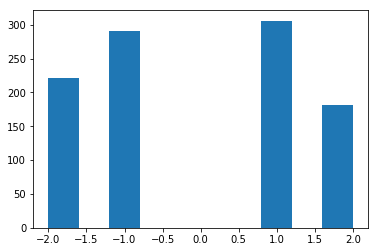

In [54]:
import matplotlib.pyplot as plt

plt.hist(s)